In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.style import use
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
use('fivethirtyeight')

In [41]:
def find_switches(s):
    y = np.zeros(len(s))
    x = s.values.squeeze()
    y[1:] = (x[0:-1] != x[1:]).astype(int)
    y[0] = 0
    return y


def rank_by_num_switches(df):
    df['switch'] = df.groupby('sid').activity.transform(find_switches).astype(int)
    if 'stage' in df.columns:
        df.loc[df.stage.ne('epochs'), 'switch'] = 0
    df['numSwitches'] = df.groupby('sid').switch.transform(sum)
    ranks = df.groupby('sid')[['sid','numSwitches']].head(1).reset_index()
    ranks['numSwitchesRank'] = ranks.numSwitches.rank(method='first').astype(int)
    df = df.merge(ranks[['sid', 'numSwitchesRank']], how='outer', on='sid')
    return df

In [131]:
df = pd.read_csv('data/ig_main.csv')
df = df.filter(items=['sid', 'stage', 'trial', 'blockTrial', 'activity', 'correct'])
df = rank_by_num_switches(df)
DF1 = df.assign(block = df.groupby('sid').switch.transform(lambda x: np.cumsum(x)))

df = pd.read_csv('data/ig_extra.csv')
DF2 = df.filter(items=['sid', 'age', 'gender'])

# Age distribution

Text(0.5, 1.0, 'N = 199')

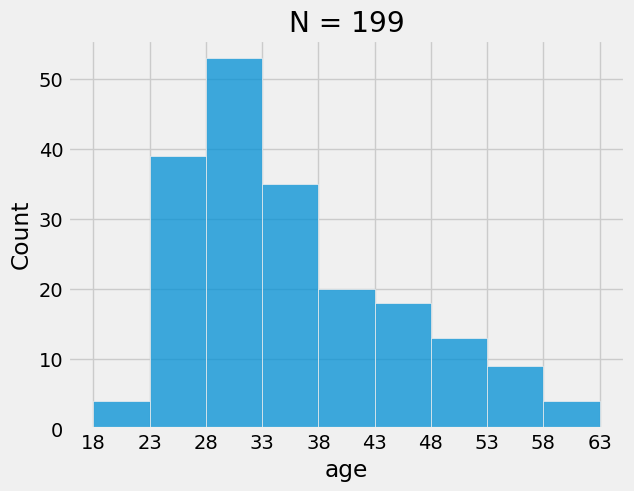

In [114]:
fig, ax = plt.subplots()
bins = [18+i*5 for i in range(10)]
sns.histplot(data=DF2, x='age', bins=bins, ax=ax)
_ = ax.set_xticks(bins)
ax.set_title(f'N = {DF2.shape[0]}')

# Exploration measures

## 1. Mean accuracy

PearsonRResult(statistic=-0.09158914472881984, pvalue=0.19938257679846566)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                correct   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.658
Date:                Tue, 13 Jun 2023   Prob (F-statistic):              0.199
Time:                        16:03:22   Log-Likelihood:                 120.59
No. Observations:                 198   AIC:                            -237.2
Df Residuals:                     196   BIC:                            -230.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7781      0.034     22.639      0.000       0.710       0.846
age           -0.0012      0.001     -1.288      0.199      -0.003       0.001
==============================================================================
Omnibus:                       16.740   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.910
Skew:                          -0.021   Prob(JB):                       0.0521
Kurtosis:                       2.155   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

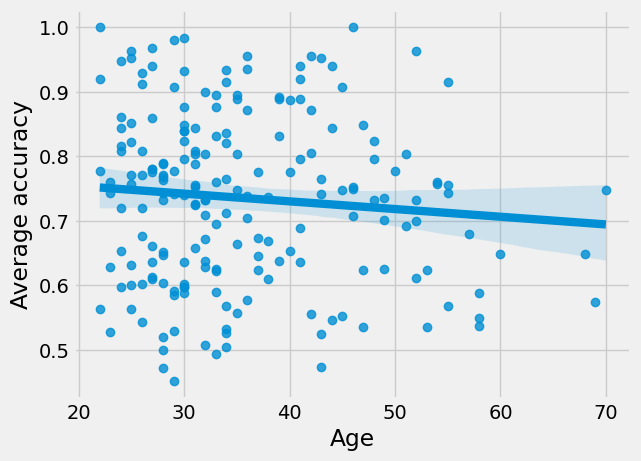

In [262]:
fix, ax = plt.subplots()
df = DF1.query('stage == \'free\'')
df = df.groupby(['sid'])[['correct']].mean()
df = df.groupby(['sid'])[['correct']].mean()
df = df.merge(DF2[['sid', 'age']], on='sid')
sns.regplot(x='age', y='correct', data=df, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Average accuracy')
fig.tight_layout()

df = df.dropna()
print(pearsonr(df.correct, df.age))
ols('correct ~ age', data = df).fit().summary()

## 2. Relative time allocation

PearsonRResult(statistic=0.17876053154857816, pvalue=0.011742585358029828)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               A3_or_A4   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     6.470
Date:                Tue, 13 Jun 2023   Prob (F-statistic):             0.0117
Time:                        16:03:46   Log-Likelihood:                -48.341
No. Observations:                 198   AIC:                             100.7
Df Residuals:                     196   BIC:                             107.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2535      0.081      3.143      0.002       0.094       0.413
age            0.0055      0.002      2.544      0.012       0.001       0.010
==============================================================================
Omnibus:                       74.585   Durbin-Watson:                   2.208
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.306
Skew:                           0.066   Prob(JB):                      0.00351
Kurtosis:                       1.837   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

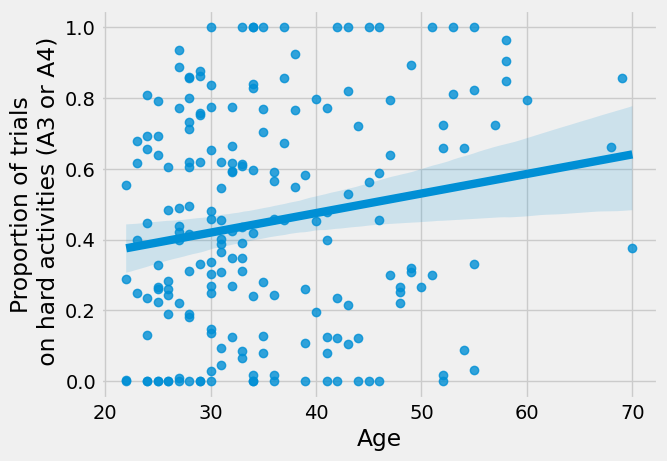

In [264]:
fix, ax = plt.subplots()
df = DF1.query('stage == \'free\'')
df = df.assign(
    isA1 = df.activity == 'A1',
    isA2 = df.activity == 'A2',
    isA3 = df.activity == 'A3',
    isA4 = df.activity == 'A4'
)
df = df.groupby('sid')[['isA1', 'isA2', 'isA3', 'isA4']].mean()
df = df.assign(
    A3_or_A4 = df.isA3 + df.isA4,
)
df = df.merge(DF2[['sid', 'age']], on='sid')

sns.regplot(data=df, x='age', y='A3_or_A4', ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Proportion of trials\n on hard activities (A3 or A4)')

df = df.dropna()
print(pearsonr(df.A3_or_A4, df.age))
ols('A3_or_A4 ~ age', data = df).fit().summary()

## 3. Self-challenge index

PearsonRResult(statistic=0.10679420059153494, pvalue=0.13426350386921188)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.261
Date:                Tue, 13 Jun 2023   Prob (F-statistic):              0.134
Time:                        16:04:12   Log-Likelihood:                 91.556
No. Observations:                 198   AIC:                            -179.1
Df Residuals:                     196   BIC:                            -172.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3851      0.040      9.675      0.000       0.307       0.464
age            0.0016      0.001      1.504      0.134      -0.001       0.004
==============================================================================
Omnibus:                       13.400   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.692
Skew:                          -0.667   Prob(JB):                     0.000645
Kurtosis:                       3.012   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

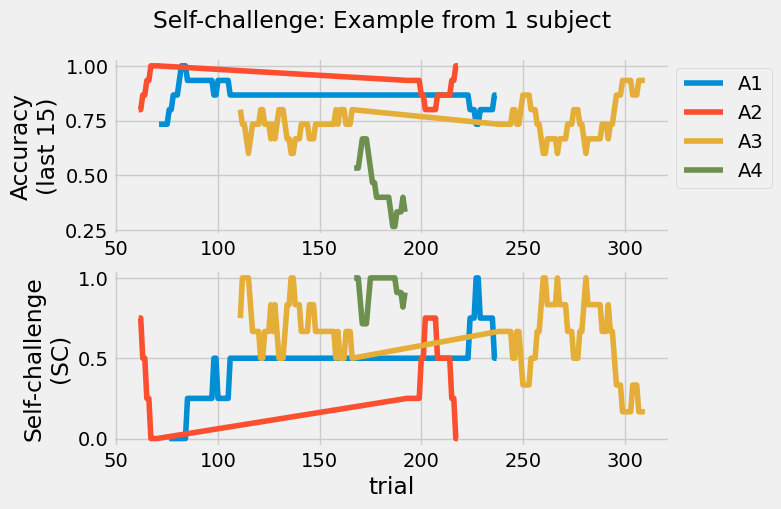

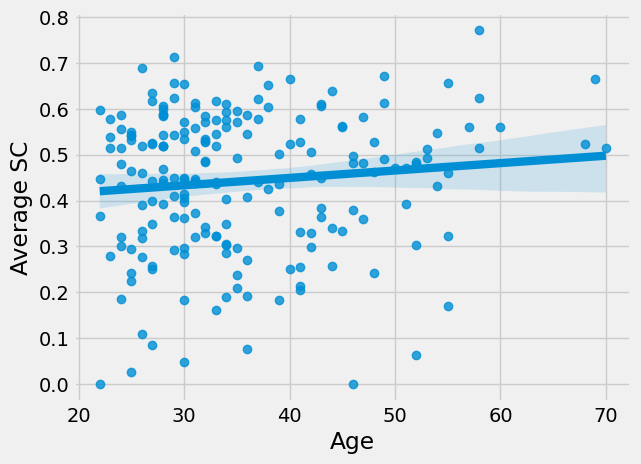

In [265]:
df = DF1.copy()
df = df.filter(items=['sid', 'stage', 'trial', 'blockTrial', 'activity', 'correct'])
df = df.set_index(['trial','stage'])
df = df.groupby(['sid', 'activity']).rolling(window=15, min_periods=1).mean()
df = df.reset_index().sort_values(by=['sid', 'activity'])
df = df.rename(columns={'correct': 'recentPC'})
df = df.assign(ones = 1)
df = df.query('stage == "free"')
df = df.merge(df.set_index(['trial','stage']).groupby('sid')[['recentPC']].rolling(window=400, min_periods=1).max().reset_index().rename(columns={'recentPC': 'maxSoFar'}), on=['sid', 'trial', 'stage'])
df = df.merge(df.set_index(['trial','stage']).groupby('sid')[['recentPC']].rolling(window=400, min_periods=1).min().reset_index().rename(columns={'recentPC': 'minSoFar'}), on=['sid', 'trial', 'stage'])
df = df.assign(
    sc = 1 - (df.recentPC - df.minSoFar) / (df.maxSoFar - df.minSoFar)
)
i = df.sid.unique()[100]
df_i = df.query('sid == @i')

# Demonstrate SC index
fix, ax = plt.subplots(num='sc demo', nrows=2)
plt.suptitle('Self-challenge: Example from 1 subject')
sns.lineplot(x='trial', y='recentPC', hue='activity', ax=ax[0], data=df_i)
ax[0].legend(bbox_to_anchor=[1.2, 1.0])
ax[0].set_xlabel('')
ax[0].set_ylabel('Accuracy\n(last 15)')
sns.lineplot(x='trial', y='sc', hue='activity', ax=ax[1], data=df_i)
ax[1].get_legend().remove()
ax[1].set_ylabel('Self-challenge\n(SC)')
fig.tight_layout()

fix, ax = plt.subplots(num='sc vs age')
df = df.groupby('sid').sc.mean().reset_index()
df = df.merge(DF2[['sid', 'age']], on='sid')
sns.regplot(data=df, x='age', y='sc', ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Average SC')


df = df.dropna()
print(pearsonr(df.sc, df.age))
ols('sc ~ age', data = df).fit().summary()

In [271]:
df = pd.read_csv('meta.csv')
# display(df.head(20))
pd.to_datetime(df.Duration).median()

/var/folders/76/f7mjh1ks5339cvcfyvzxgmy00000gp/T/ipykernel_7339/1538715826.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df.Duration).median()


Timestamp('2023-06-13 00:41:29.500000')